## Human Simulation 4x4 RNA-seq dataset

### Obtaining the reads

```
wget https://zenodo.org/record/1291375/files/out_1.tar\?download\=1 -O out_1.tar
wget https://zenodo.org/record/1291375/files/out_2.tar\?download\=1 -O out_2.tar
wget https://zenodo.org/record/1291375/files/out_3.tar\?download\=1 -O out_3.tar
wget https://zenodo.org/record/1291375/files/out_4.tar\?download\=1 -O out_4.tar
```

Love, Michael I., Charlotte Soneson, and Rob Patro. "Swimming downstream: statistical analysis of differential transcript usage following Salmon quantification." F1000Research 7 (2018).

----

Each of the folders contain a control and a treatment sample from Polyester. The folders contain the true expressions for the transcripts.

### Index human transcriptome

#### Index Human reference transcriptome

```
mkdir reference
cd reference
wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_28/gencode.v28.transcripts.fa.gz
sed -e '/^>/ s/|.*//' gencode.v28.transcripts.fa > gencode.v28.transcripts.clean.fa
cd ..
../bin/salmon-latest_linux_x86_64/bin/salmon index -t ../reference/gencode.v28.transcripts.clean.fa -i ../index/human_idx -k 31 --keepDuplicates -p 12

```

### Salmon Runs

#### Run salmon Quant

```
for i in {1..4}; do for j in {1..2}; do ../bin/salmon-latest_linux_x86_64/bin/salmon quant -i ../index/human_idx -la -1 fastq/out_${i}/out_${i}_sample_0${j}_1_shuffled.fa.gz -2 fastq/out_${i}/out_${i}_sample_0${j}_2_shuffled.fa.gz --thinningFactor 32 -p 6 --numGibbsSamples 100 -d -o quant/out_${i}_sample_0${j}; done ; done

```

#### Run salmon Alignment

```
for i in {1..4}; do for j in {1..2}; do ../bin/salmon-latest_linux_x86_64/bin/salmon quant -i ../index/human_idx -la -1 fastq/out_$i/out_${i}_sample_0${j}_1_shuffled.fa.gz -2 fastq/out_$i/out_${i}_sample_0${j}_2_shuffled.fa.gz -p 12 -z -o mmseq_quant/out_${i}_sample_0${j} --hardFilter | samtools view -bS -@12 - | samtools sort -n -@12 - -o mmseq_quant/out_${i}_sample_0${j}.bam ; done ; done

```

### Terminus Runs

#### Run terminus group

```
for i in {1..4}; do for j in {1..2}; do ../../terminus/target/release/terminus group -m 0.05 -d quant/out_${i}_sample_0${j}/ -o terminus_result/out_${i}_sample_0${j}/ ; done ; done

```

#### Run terminus collapse

```
../../terminus/target/release/terminus collapse -d quant/out_1_sample_01 quant/out_1_sample_02 quant/out_2_sample_01 quant/out_2_sample_02 quant/out_3_sample_01 quant/out_3_sample_02 quant/out_4_sample_01 quant/out_4_sample_02 -c 0.5 -o terminus_result

```

### mmcollapse Runs

#### Prepare reference for mmcollapse (it expects the fasta names to have a fixed format)

```
t2g = pd.read_csv('hg_t2g.tsv', sep = '\t',
                 header = None, names = ['transcript','gene']).set_index('transcript').to_dict()['gene']
                 
with open('gencode.v28.transcripts.mmcollapse.fa', 'w') as fp:
    for t in fa:
        fp.write('>{} gene:{}\n'.format(t,t2g[t]))
        fp.write('{}\n'.format(str(fa[t])))


```

#### Run bam2hits

```bash
for i in {1..4}; do for j in {1..2};do mmseq/bin/bam2hits ../reference/gencode.v28.transcripts.mmcollapse.fa mmseq_quant/out_${i}_sample_0${j}.bam > mmseq_quant/out_${i}_sample_0${j}.hits ; done; done

```

#### Run mmseq

```bash

for i in {1..4}; do for j in {1..2}; do OMP_NUM_THREADS=3 ../bin/mmseq/bin/mmseq mmseq_quant/out_${i}_sample_0${j}.hits mmseq_quant/out_${i}_sample_0${j}; done ; done

```

#### Run mmcollapse

```bash
../bin/mmseq/bin/mmcollapse mmseq_quant/out_1_sample_01 mmseq_quant/out_1_sample_02 mmseq_quant/out_2_sample_01 mmseq_quant/out_2_sample_02 mmseq_quant/out_3_sample_01 mmseq_quant/out_3_sample_02 mmseq_quant/out_4_sample_01 mmseq_quant/out_4_sample_0

```

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys
import readBootstraps
from collections import defaultdict

### Parsing salmon outputs

In [13]:
def group_map(gf, tnames, dup_dict = None):
    group_map = defaultdict(list)
    groups = {}
    if dup_dict is None: 
        with open(gf) as fp:
            for line in fp:
                names = line.strip().split(',')
                for n in names[1:]:
                    groups[n] = names[0]
                    group_map[names[0]].append(n)
    else:
        with open(gf) as fp:
            for line in fp:
                names = line.strip().split(',')
                for n in names[1:]:
                    if n in dup_dict:
                        groups[dup_dict[n]] = names[0]
                    groups[n] = names[0]
    for n in tnames:
        if not n in groups:
            groups[n] = n                           
    return groups,group_map


def get_salmon(
    salmon_dir,
    terminus_dir
):
    
    # Truth + Salmon
    
    samples = [1,2,3,4]
    conditions = [1,2]
    
    quant_df = {}
    quant_terminus_df = {}
    for s in samples :
        df = {}
        mdf = {}
        vdf = {}
        for c in conditions:
            df[c] = pd.read_csv(
                '{}/out_{}_sample_0{}/quant.sf'.format(salmon_dir, s, c),
                 sep = '\t'
             )
            mdf[c] =  pd.read_csv(
                '{}/out_{}_sample_0{}/quant.sf'.format(terminus_dir,s,c),
                 sep = '\t'
             )
        quant_df[s] = df.copy()
        quant_terminus_df[s] = mdf.copy()
        
    true_df = {}
    for s in samples:
        column_name = ['sample_01', 'sample_02']
        file_name = '/mnt/scratch1/hirak/ASE_Analysis/simulation/fastq/out_{}/sim_counts_matrix.csv'.format(s)
        true_df_tmp = pd.read_csv(file_name)
        for c in conditions:
            column_name += ['salmon_'+str(c)]
            true_df_tmp = true_df_tmp.join(quant_df[s][c].set_index('Name')[['NumReads']], how='outer', rsuffix='_'+str(c))
        true_df[s] = true_df_tmp.fillna(0.0).copy()
        true_df[s].columns = column_name
    
    # True group
    true_group_df = {}
    gr,gmap = group_map(
        '{}/out_1_sample_01/clusters.txt'.format(terminus_dir)
        , quant_df[1][1]['Name'].values
    )
    
    for s in samples:
        true_group_tmp = {}
        for c in conditions:
            # tg_temp = true_df[s]['sample_0'+str(c)].join
            tg = pd.DataFrame(true_df[s][['sample_0'+str(c)]].groupby(gr)['sample_0'+str(c)].sum())
            true_group_tmp[c] = tg.join(quant_terminus_df[s][c].set_index('Name')[['NumReads']])
            true_group_tmp[c].columns = ['sample_0'+str(c), 'mercury_'+str(c)]

        true_group_df[s] = true_group_tmp
        
    return {
        'salmon_with_truth': true_df,
        'terminus_with_truth': true_group_df,
        'groups':gr,
        'gmap':gmap
    }

In [14]:
salmon_terminus_res = get_salmon(
    salmon_dir = '/mnt/scratch1/hirak/ASE_Analysis/simulation/quant_witohut_decoy/',
    terminus_dir = '/mnt/scratch1/hirak/ASE_Analysis/simulation/terminus_result_without_decoy/'
)

### Parsing mmcollapse output

In [9]:
def get_mmcollapse(
    mmcollapse_dir,
    true_df
):
    samples = [1,2,3,4]
    conditions = [1,2]
    
    
    mmcollapse_df = pd.read_csv(
                '{}/out_1_sample_01.collapsed.mmseq'.format(mmcollapse_dir),
                skiprows = 1,
                sep = '\t'
            )
    mmseq_df = {}
    for s in samples:
        mmcollapse_df_tmp = {}
        mmseq_df_tmp = {}
        for c in conditions:
            with open(
                '{}/out_{}_sample_0{}.mmseq'.format(
                    mmcollapse_dir,
                    s,
                    c
                )
            ) as fp:
                numreads = int(fp.readline().strip().split(' ')[-1])
            d = pd.read_csv(
                '{}/out_{}_sample_0{}.mmseq'.format(
                    mmcollapse_dir,
                    s,
                    c
                ),
                skiprows = 1,
                sep = '\t'
            )

            d['mmseq_numreads'] = np.exp(d.log_mu_em)
            d.mmseq_numreads = d.mmseq_numreads * d.effective_length
            d.mmseq_numreads = d.mmseq_numreads / 1e9
            d.mmseq_numreads = d.mmseq_numreads * numreads
            mmseq_df_tmp[c] = d.copy()
        mmseq_df[s] = mmseq_df_tmp
    
    import re
    mmcollapse_groups = {}
    group_names = []
    grouped_transcripts_mmcollapse = []
    for t in mmcollapse_df.feature_id.values:
        if ('+' in t) or ('*' in t):
            cands = re.split('\+|\*', t)
            for c in cands:
                mmcollapse_groups[c] = t
                grouped_transcripts_mmcollapse += [c]
            group_names += [t]
        else:
            mmcollapse_groups[t] = t
            
    true_mmcollapse_df = {}
    for s in samples:
        true_mmcollapse_tmp = {}
        for c in conditions:
            tg = pd.DataFrame(true_df[s][['sample_0'+str(c)]].groupby(mmcollapse_groups)['sample_0'+str(c)].sum())
            mmg = pd.DataFrame(mmseq_df[s][c].set_index('feature_id')[['mmseq_numreads']].groupby(
                mmcollapse_groups)['mmseq_numreads'].sum())
            true_mmcollapse_tmp[c] = tg.join(mmg).fillna(0)
            true_mmcollapse_tmp[c].columns = ['sample_0'+str(c), 'mmcollapse_'+str(c)]
        true_mmcollapse_df[s] = true_mmcollapse_tmp
        
    return {
        'mmcollapse_df' : true_mmcollapse_df,
        'groups' : mmcollapse_groups
    }

In [11]:
mmcollapse_res = get_mmcollapse(
    mmcollapse_dir = '/mnt/scratch1/hirak/ASE_Analysis/simulation/mmseq_quant/',
    true_df = salmon_terminus_res['salmon_with_truth']
)

### Calculate Spearman and MARD

In [18]:
def relDiff(c1, c2, DF, cutoff=0.01, verbose=False):
    import pandas as pd
    """
    Computes the relative difference between the values
    in columns c1 and c2 of DF.
    c1 and c2 are column names and DF is a Pandas data frame.
    Values less than cutoff will be treated as 0.

    The relative difference is defined as

    d(x_i, y_i) =
        0.0 if x_i and y_i are 0
        (x_i - y_i) / (|x_i + y_i|) otherwise

    This function returns two values.

    rd is a DataFrame where the "relDiff" column contains all
    of the computed relative differences.

    nz is a set of indexes into rd for data points where
    x_i and y_i were not *both* zero.
    """
    import numpy as np
    rd = pd.DataFrame(data = {"Name" : DF.index, "relDiff" : np.zeros(len(DF.index))*np.nan})
    rd.set_index("Name", inplace=True)
    bothZero = DF.loc[(DF[c1] < cutoff) & (DF[c2] < cutoff)].index
    nonZero = DF.index.difference(bothZero)
    if (verbose):
        print("Zero occurs in both columns {} times".format(len(rd.loc[bothZero])))
        print("Nonzero occurs in at least 1 column {} times".format(len(rd.loc[nonZero])))
    allRD = 2.0 * ((DF[c1] - DF[c2]) / (DF[c1] + DF[c2]).abs())
    assert(len(rd.loc[nonZero]["relDiff"]) == len(allRD[nonZero]))
    rd["relDiff"][nonZero] = allRD[nonZero]
    if len(bothZero) > 0:
        rd["relDiff"][bothZero] = 0.0
    return rd, nonZero

def calculate_spearman_mard(
    true_df,
    true_group_df,
    mmcollapse_df
):
    samples = [1,2,3,4]
    conditions = [1,2]
    results = []
    for s in samples:
        results += [["salmon",s,1,
                  true_df[s][['sample_01','salmon_1']].corr(method='spearman').values[0][1],
                  relDiff('sample_01','salmon_1',true_df[s])[0]['relDiff'].abs().mean()
                       ]]
        results += [["salmon",s,2 ,
              true_df[s][['sample_02','salmon_1']].corr(method='spearman').values[0][1],
              relDiff('sample_02','salmon_2',true_df[s])[0]['relDiff'].abs().mean()
                   ]]

        for c in conditions:
            results += [["terminus",s, c,
                  true_group_df[s][c][['sample_0'+str(c),'mercury_'+str(c)]].corr(method='spearman').values[0][1],
                  relDiff('sample_0'+str(c),'mercury_'+str(c),true_group_df[s][c])[0]['relDiff'].abs().mean()
                       ]]
            results += [["mmcollapse",s, c,
                  mmcollapse_df[s][c][['sample_0'+str(c),'mmcollapse_'+str(c)]].corr(method='spearman').values[0][1],
                  relDiff('sample_0'+str(c),'mmcollapse_'+str(c),mmcollapse_df[s][c])[0]['relDiff'].abs().mean()
                       ]]
    result_df = pd.DataFrame(results)
    result_df.columns = ['method','sample','condition','correlation','mard']
    return {
        'acc_df':result_df
    }

In [19]:
acc_res = calculate_spearman_mard(
    salmon_terminus_res['salmon_with_truth'],
    salmon_terminus_res['terminus_with_truth'],
    mmcollapse_res['mmcollapse_df']
)

#### The MARD and Spearman Results (mean over 8 samples)

In [20]:
acc_res['acc_df'].groupby(['method'])['correlation','mard'].mean()

,correlation,mard
method,,
mmcollapse,0.784593,0.153423
salmon,0.947331,0.115850
terminus,0.965681,0.096116


### Other plots from this dataset

#### InfRV gain from the dataset

In [35]:
roll_df = pd.read_csv(
    '/mnt/scratch1/hirak/ASE_Analysis/simulation/terminus_result_without_decoy/out_1_sample_01/die_roll.log',
    sep = '\t',
    names = ['mean_1','mean_2','infrv_1','infrv_2','metric']
)

In [36]:
roll_df['mean_sum'] = roll_df.mean_1 + roll_df.mean_2

In [ ]:
#### 

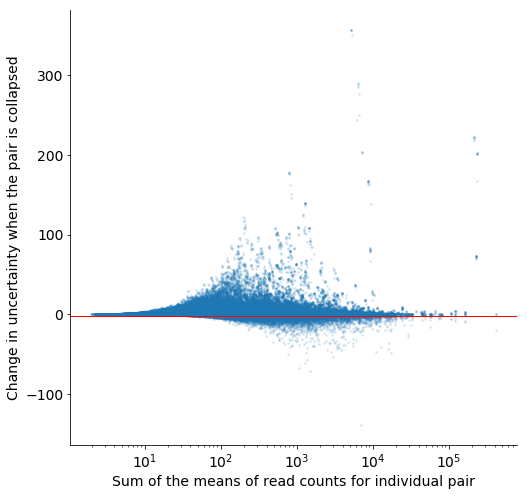

In [37]:
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x = 'mean_sum',y = 'metric', 
                data = roll_df , 
                     s = 6, 
                     linewidth=0,
                    alpha = 0.2)
#sns.scatterplot(x = 'mean_1',y = 'ratio', data = roll_df, s = 6, linewidth=0)
#plt.hlines(y=-5,xmin=0,xmax = 500000,colors='red')
ax.tick_params(axis='y', labelsize=14)
#ax.tick_params(axis='y', labelsize=14)
transform=ax.get_xaxis_transform()
plt.axhline(-1.8,linewidth=1.0, color = 'r')
#plt.text(pow(10,4),-20.2,"Cut-off from background $\mathcal{B}$",fontsize=13)
plt.ylabel('Change in uncertainty when the pair is collapsed', fontsize = 14)
plt.xlabel('Sum of the means of read counts for individual pair', fontsize = 14)
plt.tick_params(axis='x', labelsize=14)
plt.xscale('log')
sns.despine()

#### Convergence Plot

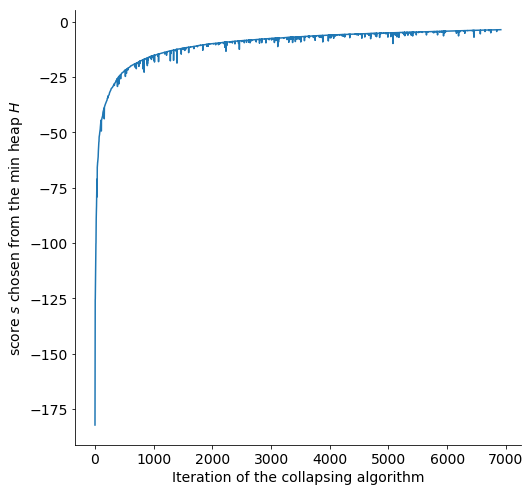

In [38]:
collapsed_df = pd.read_csv(
    '/mnt/scratch1/hirak/ASE_Analysis/simulation/terminus_result_without_decoy/out_1_sample_01/collapsed.log',
    sep = '\t',
    names = ['source','target','a','b','score']
)

plt.figure(figsize=(8, 8))
ax = plt.plot(collapsed_df.score.values)
plt.ylabel('score $s$ chosen from the min heap $H$', fontsize = 14)
plt.xlabel('Iteration of the collapsing algorithm', fontsize = 14)
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
sns.despine()

#### Gain in uncertainty the Gibbs Samples 

In [46]:
def get_gibbs(folder_name):
    txp_names , bootstrapList = readBootstraps.getBootstraps(
        folder_name,
    )
    gibbs_df_salmon = pd.DataFrame(bootstrapList).T
    gibbs_df_salmon.index = txp_names

    return gibbs_df_salmon

def computeInfRV(y, pc=5.0, shift=.1):
    infvar = np.var(y)
    mu = y.mean()
    infvar = infvar - mu
    infvar = max(infvar, 0)
    infvar = infvar / (mu + pc) + shift
    return infvar

In [41]:
## Prepare gene family and gene data

def build_group_df(gf,t2g,t2f):
    results = []
    group_map = defaultdict(list)
    with open(gf) as fp:
        for line in fp:
            names = line.strip().split(',')
            num_transcripts= 0
            genes_set = set()
            fam_set = set()
            for n in names[1:]:
                group_map[names[0]].append(n)
                if t2f[n] != 'noinfo':
                    num_transcripts += 1
                    genes_set.add(t2g[n])
                    fam_set.add(t2f[n])
            if num_transcripts > 0:   
                results += [[names[0], num_transcripts, len(genes_set), len(fam_set)]]
    df = pd.DataFrame(results, columns=['group_id','num_transcripts','num_genes', 'num_families'])
    return {
        'df': df,
        'groups':group_map
    }

gene_family_df = pd.read_csv(
    '/mnt/scratch1/hirak/ASE_Analysis/family/gene_with_protein_product2.txt',
    sep = '\t'
)
t2g = pd.read_csv('/mnt/scratch1/hirak/ASE_Analysis/reference/hg_t2g.tsv', sep = '\t',
                 header = None, names = ['transcript','gene']).set_index('transcript').to_dict()['gene']
t2g_df = pd.read_csv('/mnt/scratch1/hirak/ASE_Analysis/reference/hg_t2g.tsv', sep = '\t',
                 header = None, names = ['transcript','gene'])

t2g_df['ensemble_name'] = t2g_df.gene.str.split('.').str[0]
gene_family_joined = pd.merge(gene_family_df, t2g_df, 
         left_on='Ensembl gene ID', 
         right_on='ensemble_name',
         how = 'right'
        )[['Approved symbol', 'transcript', 'gene', 'Approved name', 'Gene group name']]
gene_family_joined.fillna('noinfo',inplace=True)
t2f = gene_family_joined[['transcript','Approved symbol']].set_index('transcript').to_dict()['Approved symbol']

In [49]:
hg_isoform_info = build_group_df(
    '/mnt/scratch1/hirak/ASE_Analysis/simulation/terminus_result_without_decoy/out_1_sample_02/clusters.txt',
    t2g,
    t2f,
)

In [40]:
gibbs_df_mercury = get_gibbs(
    '/mnt/scratch1/hirak/ASE_Analysis/simulation/terminus_result_without_decoy/out_1_sample_02/'
)
gibbs_df_salmon = get_gibbs(
    '/mnt/scratch1/hirak/ASE_Analysis/simulation/quant_witohut_decoy/out_1_sample_02/'
)

INFO:root:Expecting bootstrap info for 196184 transcripts
INFO:root:read all bootstrap values
INFO:root:read bootstraps successfully.
INFO:root:Expecting bootstrap info for 203835 transcripts
INFO:root:read all bootstrap values
INFO:root:read bootstraps successfully.


In [50]:
card2groups = hg_isoform_info['df'].loc[
    (hg_isoform_info['df'].num_transcripts == 2) &
    (hg_isoform_info['df'].num_genes == 1)
].group_id.values

In [51]:
infrv_vec = []
for g in card2groups:
    infa = computeInfRV(gibbs_df_salmon.loc[hg_isoform_info['groups'][g][0]].values)
    infb = computeInfRV(gibbs_df_salmon.loc[hg_isoform_info['groups'][g][1]].values)
    infc = computeInfRV(gibbs_df_mercury.loc[g].values)
    infd = infc - (infa + infb)/2. 
    infrv_vec += [[g,infd]]
infrv_df = pd.DataFrame(infrv_vec, columns=['group_id','infRV_diff'])

In [52]:
sorted_group_ids = infrv_df.sort_values('infRV_diff').group_id.values

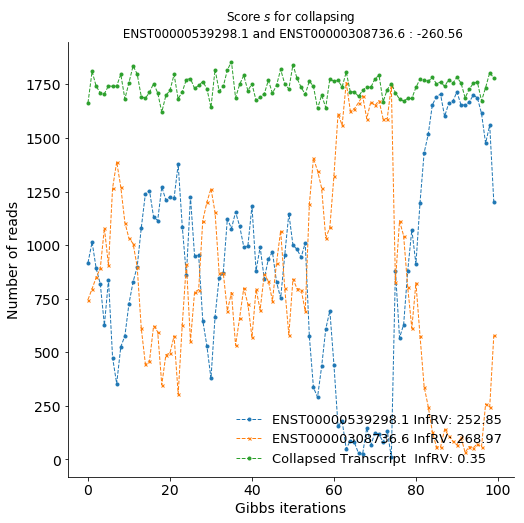

In [55]:
group_id = sorted_group_ids[1]
plt.figure(figsize=(8,8))

infa = computeInfRV(gibbs_df_salmon.loc[hg_isoform_info['groups'][group_id][0]].values)
infb = computeInfRV(gibbs_df_salmon.loc[hg_isoform_info['groups'][group_id][1]].values)
infc = computeInfRV(gibbs_df_mercury.loc[group_id].values)
infd = infc - (infa + infb)/2.
plt.plot(gibbs_df_salmon.loc[hg_isoform_info['groups'][group_id][0]].values,
         label='{} InfRV: {:0.2f}'.format(hg_isoform_info['groups'][group_id][0], infa),
         marker = 'o',
         linestyle='dashed',
         markersize = 3.,
         linewidth = 1.0
        )
plt.plot(gibbs_df_salmon.loc[hg_isoform_info['groups'][group_id][1]].values, 
         label='{} InfRV: {:0.2f}'.format(hg_isoform_info['groups'][group_id][1], infb),
         marker = 'x',
         linestyle='dashed',
         markersize = 3.,
         linewidth = 1.0
        )
plt.plot(gibbs_df_mercury.loc[group_id].values, 
         label = 'Collapsed Transcript  InfRV: {:0.2f}'.format(infc),
         marker = 'o',
         linestyle='dashed',
         markersize = 3.,
         linewidth = 1.0
        )
plt.title('Score $s$ for collapsing \n {} and {} : {:0.2f}'.format(
        hg_isoform_info['groups'][group_id][0],
        hg_isoform_info['groups'][group_id][1],
        infd
    )
)
plt.xlabel('Gibbs iterations', fontsize = 14)
plt.ylabel('Number of reads', fontsize = 14)
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
sns.despine()
plt.legend(frameon=False, loc ='lower right',fontsize=13)

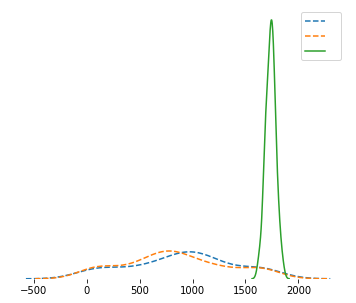

In [57]:
plt.figure(figsize=(6,5))
sns.distplot(
    gibbs_df_salmon.loc[hg_isoform_info['groups'][group_id][0]].values,
    kde = True,
    hist = False,
    kde_kws=dict(linewidth=1.5,linestyle='dashed'),
    label = ' '
    
)
sns.distplot(
    gibbs_df_salmon.loc[hg_isoform_info['groups'][group_id][1]].values,
    kde = True,
    hist = False,
    kde_kws=dict(linewidth=1.5,linestyle='dashed'),
    label = ' '
)

ax = sns.distplot(
    gibbs_df_mercury.loc[group_id].values,
    kde = True,
    hist = False,
    kde_kws=dict(linewidth=1.5),
    label = " "
)
ax.set_frame_on(False)
ax.axes.get_yaxis().set_visible(False)
#plt.legend(frameon=False, fontsize = 15, markerscale=10.)

sns.despine()

---------------------------------------------

### Increasing resolution of the experiment (Plots in supplement)

In [62]:
swim_salmon_1 = salmon_terminus_res['salmon_with_truth'][1].copy()

In [63]:
transcripts_nz = swim_salmon_1.loc[(swim_salmon_1.sample_02 != 0) & (swim_salmon_1.salmon_2 !=0)].index

In [64]:
swim_salmon_1.loc[:,'true_log_ratio'] = np.log(swim_salmon_1.sample_01 + 1) - np.log(swim_salmon_1.sample_02 + 1)
swim_salmon_1.loc[:,'salmon_log_ratio'] = np.log(swim_salmon_1.salmon_1 + 1) - np.log(swim_salmon_1.salmon_2 + 1)
swim_salmon_1.loc[:,'abs_diff'] = np.abs(swim_salmon_1.true_log_ratio - swim_salmon_1.salmon_log_ratio)

#### Select part of dataframe where true log fold change varies from estimated log fold change

In [65]:
swim_wrong_ratio =  swim_salmon_1.loc[
    (((swim_salmon_1.true_log_ratio > 0) & (swim_salmon_1.salmon_log_ratio < 0)) |
    ((swim_salmon_1.true_log_ratio < 0.) & (swim_salmon_1.salmon_log_ratio > 0.))) &
    (swim_salmon_1.abs_diff > 0.5)
]

#### Supplementary Figure S5

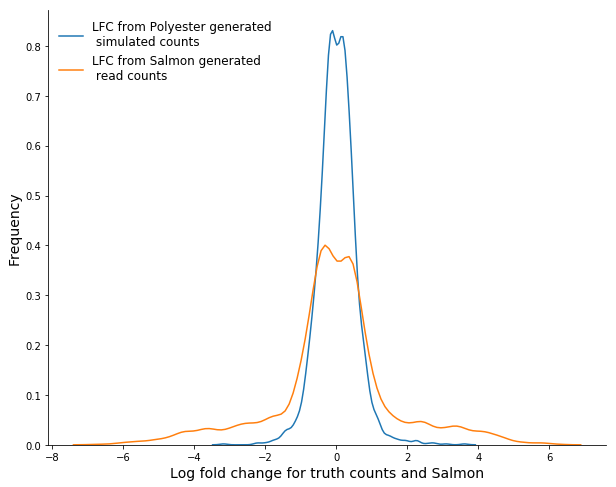

In [66]:
plt.figure(figsize=(10,8))
sns.distplot(
    swim_wrong_ratio.true_log_ratio,
    kde = True,
    hist = False,
    kde_kws=dict(linewidth=1.5),
    label = "LFC from Polyester generated \n simulated counts"
)

sns.distplot(
    swim_wrong_ratio.salmon_log_ratio,
    kde = True,
    hist = False,
    kde_kws=dict(linewidth=1.5),
    label = "LFC from Salmon generated \n read counts"
)
plt.xlabel('Log fold change for truth counts and Salmon',fontsize = 14)
plt.ylabel('Frequency',fontsize = 14)
plt.legend(frameon=False, loc ='upper left',fontsize=12)
sns.despine()

In [67]:
swim_group = pd.DataFrame.from_dict(salmon_terminus_res['groups'], orient='index')

In [68]:
correct_groups = swim_group.loc[
    swim_group.index.isin(swim_wrong_ratio.index.values) & swim_group[0].str.contains('NewTr')][0].values
correct_groups_transcripts = swim_group.loc[
    swim_group.index.isin(swim_wrong_ratio.index.values) & swim_group[0].str.contains('NewTr')].index.values
terminus_maps = swim_group.loc[
    swim_group.index.isin(swim_wrong_ratio.index.values)][0].values

In [74]:
swim_wrong_ratio.loc[:,'group_status'] = 'No'
swim_wrong_ratio.loc[correct_groups_transcripts,'group_status'] = 'Yes'
df = swim_wrong_ratio[['sample_01','salmon_1','group_status']]
df.loc[:,'sample_01'] = np.log(df.sample_01 + 1)
df.loc[:,'salmon_1'] = np.log(df.salmon_1 + 1)
df2 = salmon_terminus_res['terminus_with_truth'][1][1].loc[terminus_maps]
df1 = df.join(swim_group.loc[swim_wrong_ratio.index]).reset_index()
df1.columns = ['transcript_name','sample_01','salmon_1','group_status','group_name']
df3 = np.log(df2+1).reset_index()
df3.columns = ['group_name','sample_01','mercury_1']
print(df1.shape, df3.shape)
df4 = pd.merge(
    df1,
    df3,
    on = 'group_name'
)
df4.drop_duplicates(inplace=True)
print(df4.shape)


(2194, 5) (2194, 3)
(2194, 7)


/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Supplementary Figure S6

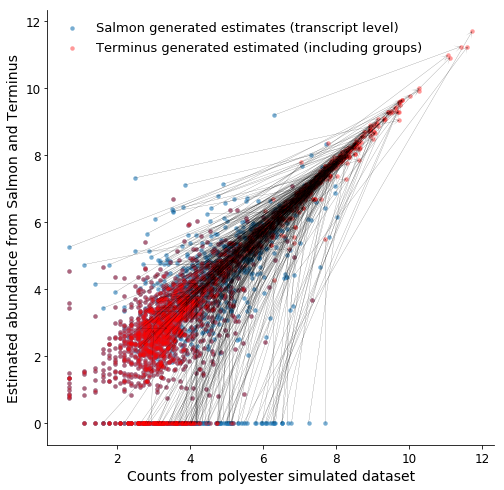

In [75]:
X_pos = df4.loc[df4.group_name.str.contains('NewTr')]['sample_01_x'].values
Y_pos = df4.loc[df4.group_name.str.contains('NewTr')]['salmon_1'].values
X_direct = df4.loc[df4.group_name.str.contains('NewTr')]['sample_01_y'].values
X_direct = X_direct - X_pos
Y_direct = df4.loc[df4.group_name.str.contains('NewTr')]['mercury_1'].values
Y_direct = Y_direct - Y_pos
plt.figure(figsize=(8, 8))

ax = sns.scatterplot(
    x = 'sample_01_x',
    y = 'salmon_1',
    #hue = "group_status",
    data = df4,
    s=20,
    linewidth=0,
    alpha = 0.6,
    label = 'Salmon generated estimates (transcript level)'
)

ax = sns.scatterplot(
    x = 'sample_01_y',
    y = 'mercury_1',
    data = df4,
    s=20,
    linewidth=0,
    alpha = 0.4,
    color = 'r',
    label = 'Terminus generated estimated (including groups)'
)


# fig, ax = plt.subplots()
q = ax.quiver(X_pos, Y_pos, X_direct, Y_direct, angles = 'xy', width = 0.0003,scale_units='xy',
              scale = 1,
              headwidth = 50,
              headlength = 50
             )
plt.ylabel('Estimated abundance from Salmon and Terminus',fontsize = 14)
plt.xlabel('Counts from polyester simulated dataset',fontsize = 14)
plt.legend(frameon=False, loc ='upper left',fontsize=13)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
sns.despine()

#### Change of variance

In [79]:
swim_salmon_group_size = swim_group.loc[
    swim_group[0].str.contains('NewTr')
].reset_index().groupby(0)['index'].size().reset_index()
swim_salmon_group_size.columns = ['group_name','group_size']
swim_group_size_two_names = swim_salmon_group_size.loc[
    swim_salmon_group_size.group_size == 2
]['group_name'].values

swim_group_transcripts = [salmon_terminus_res['gmap'][k] for k in swim_group_size_two_names]
variance_trio_df = pd.DataFrame([
    sorted(gibbs_df_salmon.loc[swim_group_transcripts[i]].var(1).values) + 
    [gibbs_df_mercury.loc[swim_group_size_two_names[i]].var()]
    for i in range(len(swim_group_size_two_names))
],
columns = ['higher_var','lower_var','merged_var']
)

variance_trio_df.loc[:,'var_mean'] = variance_trio_df[['higher_var','lower_var']].mean(1).values

#### Supplement Figure S2

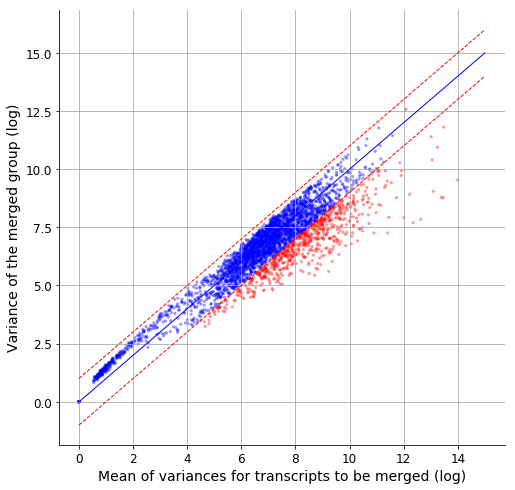

In [80]:
plt.figure(figsize=(8, 8))
df = np.log(variance_trio_df[['var_mean','merged_var']]+1)
df.loc[:,'color'] = 'b'
df.loc[(df.merged_var - df.var_mean) < -1, 'color'] = 'r'
colors = ["b", "r"]
customPalette = sns.set_palette(sns.color_palette(colors))
ax = sns.scatterplot(
    x = 'var_mean', 
    y = 'merged_var',
    data = df,
    hue='color',
    s=10,
    linewidth=0,
    alpha = 0.4,
    palette=customPalette
)
ax.get_legend().remove()
#plt.loglog(x,y)
plt.plot(np.linspace(0,15,num=16), np.linspace(0,15,num=16),linewidth=1.0)
plt.plot(np.linspace(0,15,num=16), np.linspace(0,15,num=16)-1,'--',linewidth=1.0,color='r')
plt.plot(np.linspace(0,15,num=16), np.linspace(0,15,num=16)+1,'--',linewidth=1.0,color='r')
plt.grid(True,which="both",ls="-", color='0.65')
             
plt.xlabel('Mean of variances for transcripts to be merged (log)',fontsize = 14)
plt.ylabel('Variance of the merged group (log)',fontsize = 14)
#plt.legend(frameon=False, loc ='upper left',fontsize=13)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
sns.despine()

### Gene Family Analysis

In [84]:
t2g_orig = pd.read_csv(
    '/mnt/scratch1/hirak/ASE_Analysis/reference/hg_t2g.tsv',sep = '\t',header = None, 
    names=['transcript','gene'])
t2g_orig.loc[:,'gene_wo_version'] = t2g_orig.gene.str.split('.').str[0]

t2g = t2g_orig.groupby('gene').count().sort_values('transcript',ascending=False).reset_index()
t2g.gene = t2g.gene.str.split('.').str[0]

with open('/mnt/scratch1/hirak/ASE_Analysis/reference/family_hg.txt') as fp:
    line_num = 1
    lines = []
    mal_formed_lines = []
    for line in fp:
        if len(line.strip().split('\t')) == 7:
            lines += [line.strip().split('\t')]
        else :
            mal_formed_lines += [line_num]
        line_num += 1
        
hg_family_df = pd.DataFrame(lines[1:], columns=lines[0])

hg_family_df.drop_duplicates(subset=['Ensembl gene ID'],inplace=True)
family_isoform_info = pd.merge(
    t2g,
    hg_family_df[['Family name','Ensembl gene ID']],
    left_on = 'gene',
    right_on = 'Ensembl gene ID',
    how = 'inner'
)

family_isoform_info_coding_RNA = family_isoform_info.loc[family_isoform_info['Family name'] != 'Non-coding RNAs']
family_isoform_info_coding_RNA_counts = family_isoform_info_coding_RNA[['gene','transcript','Family name']].groupby(
    'Family name'
).agg({'gene':'count', 'transcript':sum}).reset_index()

family_isoform_info_coding_RNA_counts.loc[:,'t2g_ratio'] = ( 
    family_isoform_info_coding_RNA_counts.transcript /
    family_isoform_info_coding_RNA_counts.gene
)
family_isoform_info_coding_RNA_counts.sort_values('t2g_ratio', ascending=False, inplace=True)

In [86]:
swim_terminus_group = swim_group.reset_index()
swim_terminus_group.columns = ['transcript_name', 'group_name']
swim_terminus_group = pd.merge(
    swim_terminus_group,
    t2g_orig,
    left_on = 'transcript_name',
    right_on = 'transcript',
    how = 'inner'
)


swim_terminus_family = pd.merge(
    family_isoform_info_coding_RNA,
    swim_terminus_group,
    left_on = 'gene',
    right_on = 'gene_wo_version',
    how = 'inner'
)[['gene_x','Family name','transcript_y','group_name']]
swim_terminus_group_family = swim_terminus_family.loc[swim_terminus_family.group_name.str.contains('NewTr')]

#### Supplementary Figure S9

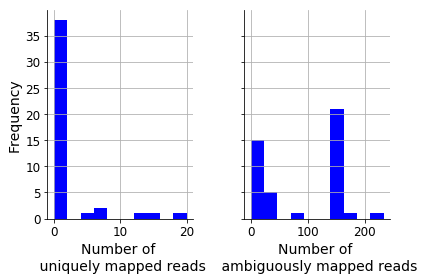

In [88]:
quant_info = pd.concat([
    pd.read_csv(
    '/mnt/scratch1/hirak/ASE_Analysis/simulation/quant_witohut_decoy/out_1_sample_01/quant.sf',
    sep = '\t'
),
pd.read_csv(
    '/mnt/scratch1/hirak/ASE_Analysis/simulation/quant_witohut_decoy/out_1_sample_01/aux_info/ambig_info.tsv',
    sep = '\t'
)]
    ,axis =1)

quant_info_p = quant_info.set_index('Name').loc[
    swim_terminus_family.loc[swim_terminus_family['Family name'] == 'Clustered protocadherins'
                        ]['transcript_y'].values
]

tmp = quant_info_p.loc[((quant_info_p.UniqueCount != 0) | (quant_info_p.AmbigCount != 0))][
    ['UniqueCount', 'AmbigCount']
]

#tmp.columns = ['Number of \n uniquely mapped reads', 'Number of \n ambiguously mapped reads']
fig, axes = plt.subplots(1, 2,sharey=True)
tmp.hist('UniqueCount', ax=axes[0])
tmp.hist('AmbigCount', ax=axes[1])
axes[0].set_title('')
axes[1].set_title('')
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[0].set_xlabel('Number of \n uniquely mapped reads',fontsize = 14)
axes[1].set_xlabel('Number of \n ambiguously mapped reads',fontsize = 14)
axes[0].set_ylabel('Frequency',fontsize = 14)
sns.despine()
plt.tight_layout()
plt.show()